k values: [0.15707963 0.4712389  0.78539816 1.09955743 1.41371669 1.72787596
 2.04203522 2.35619449 2.67035376 2.98451302]


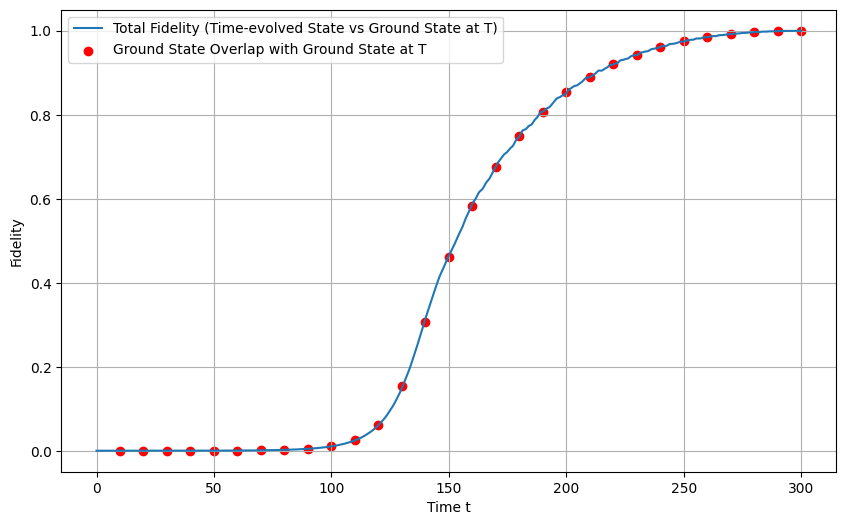

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定数
a = 1.0    # 格子定数
ℏ = 1.0    # プランク定数
N = 20     # スピンの数（偶数）
g_1 = 1.0  # ドライバーハミルトニアンの磁場の強さ
g_2 = 0.2  # 問題ハミルトニアンの磁場の強さ

def make_Hamiltonian_per_k(J, Jg, a, k):
    # ハミルトニアン作成関数
    Driver_Hamiltonian = -2 * Jg * g_1 * (np.identity(2)-np.array([[0, 0], [0, 1]]))
    Problem_Hamiltonian = 2 * J * (-np.cos(k * a) * np.array([[0, 0], [0, 1]]) + np.sin(k * a) * np.array([[0, 1], [1, 0]]) + g_2 * (np.identity(2)-np.array([[0, 0], [0, 1]])))
    return  Driver_Hamiltonian + Problem_Hamiltonian

def get_k_values(N, a):
    # 波数 k
    n_values = range(N // 2)
    k_values_positive = []
    for n in n_values:
        k_value = (2 * np.pi / (N * a)) * (n + 0.5)
        k_values_positive.append(k_value)
    k_values = np.array(k_values_positive) 
    return k_values

def rungekutta_first_order(f, t0, x0, te, h):
    # 1階の微分方程式を解くための4次ルンゲクッタ法
    ts = np.arange(t0, te + h, h)
    xs = []
    x = x0
    for t in ts:
        xs.append(x)
        k1 = h * f(t, x)
        k2 = h * f(t + h / 2, x + k1 / 2)
        k3 = h * f(t + h / 2, x + k2 / 2)
        k4 = h * f(t + h, x + k3)
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return ts, np.array(xs)

# 初期状態
ψ0 = np.array([1, 0], dtype=complex)

# 初期時刻
t0 = 0
# 終了時刻
te = 300
# ステップ幅
h = 0.01     

# k 値を取得
k_values = get_k_values(N, a)
print("k values:", k_values)

# 時間配列を作成
ts = np.arange(t0, te + h, h)

# psi_k_arrayを計算
psi_k_list = []

for k in k_values:
    # シュレディンガー方程式を定義
    def f_Schrodinger_equation(t, ψ):
        # 時間依存のJとJgを計算
        J = t / te
        Jg = 1 - t / te
        # ハミルトニアンを計算
        H_k = make_Hamiltonian_per_k(J, Jg, a, k)
        return -1j * np.dot(H_k, ψ) / ℏ

    # シュレディンガー方程式を解く
    _, ψs = rungekutta_first_order(f_Schrodinger_equation, t0, ψ0, te, h)

    # 現在の k に対する結果を保存
    psi_k_list.append(ψs)

# リストを配列に変換
psi_k_array = np.array(psi_k_list)

# 最終時刻 te における基底状態を各 k について計算し保存
ground_state_T_list = []

for k in k_values:
    # 時刻 te における J と Jg を計算
    J_T = 1 
    Jg_T = 0 

    # ハミルトニアンを計算
    H_k_T = make_Hamiltonian_per_k(J_T, Jg_T, a, k)

    # ハミルトニアンの基底状態を計算
    eigenvalues, eigenvectors = np.linalg.eigh(H_k_T)
    # 固有値を昇順にソート
    idx = eigenvalues.argsort()
    eigenvectors = eigenvectors[:, idx]
    # 基底状態をリストに保存
    ground_state_T = eigenvectors[:, 0]  
    ground_state_T_list.append(ground_state_T)

# フィデリティの計算とプロットを行う
F_total_T = np.ones(len(ts))

for idx_t, t in enumerate(ts):
    F_k_t = []
    for idx_k, k in enumerate(k_values):
        # 数値計算で得られた ψ_k(t)
        psi_k_t = psi_k_array[idx_k, idx_t, :]
        # 最終時刻の基底状態を取得
        ground_state_T = ground_state_T_list[idx_k]
        # 内積を計算
        inner_product = np.vdot(ground_state_T, psi_k_t)
        # フィデリティを計算
        F_k = np.abs(inner_product)**2
        F_k_t.append(F_k)
    # 各 k に対するフィデリティの積を計算
    F_total_T[idx_t] = np.prod(F_k_t)

# 新たに追加する部分：指定した時刻での基底状態同士のフィデリティを計算
specified_times = np.arange(10, te + h, 10)  # t = 10, 20, ..., 100
F_total_specified = []

for t in specified_times:
    F_k_specified_t = []
    for idx_k, k in enumerate(k_values):
        # 時刻 t における J と Jg を計算
        J_t = t / te
        Jg_t = 1 - t / te

        # ハミルトニアンを計算
        H_k_t = make_Hamiltonian_per_k(J_t, Jg_t, a, k)

        # ハミルトニアンの基底状態を計算
        eigenvalues_t, eigenvectors_t = np.linalg.eigh(H_k_t)
        # 固有値を昇順にソート
        idx_t_sort = eigenvalues_t.argsort()
        eigenvectors_t = eigenvectors_t[:, idx_t_sort]
        ground_state_t = eigenvectors_t[:, 0]

        # 最終時刻の基底状態を取得
        ground_state_T = ground_state_T_list[idx_k]

        # 内積を計算
        inner_product = np.vdot(ground_state_T, ground_state_t)
        # フィデリティを計算
        F_k = np.abs(inner_product)**2
        F_k_specified_t.append(F_k)
    # 各 k に対するフィデリティの積を計算
    F_total_specified.append(np.prod(F_k_specified_t))

# フィデリティのプロット
plt.figure(figsize=(10, 6))
plt.plot(ts, F_total_T, label='Total Fidelity (Time-evolved State vs Ground State at T)')
plt.scatter(specified_times, F_total_specified, color='red', label='Ground State Overlap with Ground State at T')
plt.xlabel('Time t')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(True)
plt.show()
